# GTEx data

Download using the following commands.
`wget https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt`

`wget https://storage.googleapis.com/adult-gtex/bulk-gex/v8/rna-seq/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz`

This notebook must be run in the `benchmark_env` conda environment.

In [1]:
library(edgeR)
library(limma)
library(ggplot2)
library(dplyr)
library(data.table)
library(biomaRt)
library(GSEABase)

Loading required package: limma


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int

In [2]:
# Load counts for protein coding genes.
gtex_counts_n10 <- fread("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz", nrows=10)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4505951,240.7,8250257,440.7,5625015,300.5
Vcells,7966087,60.8,15504938,118.3,12718225,97.1


In [3]:
# Load sample annotations and only keep those with counts.
gtex_annot <- fread("GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt")
gtex_annot <- gtex_annot[gtex_annot$SAMPID %in% colnames(gtex_counts_n10),]
gtex_annot$SMTS <- gsub(" ", ".", gtex_annot$SMTS, fixed=T)
gtex_annot <- gtex_annot[gtex_annot$SMTS %in% c("Brain", "Muscle", "Kidney", "Liver"),]

In [7]:
# Sample at most 10 data sets per tissue.
sel <- c()
n_samples <- 10
for (tissue in unique(gtex_annot$SMTS) ) {
    n_tissue <- sum(gtex_annot$SMTS == tissue)
    if(n_tissue > n_samples) {
        sel <- c(sel, 
                 sample(which(gtex_annot$SMTS == tissue),
                        replace = FALSE,size = min(n_tissue, n_samples)))
    }
}
gtex_annot <- gtex_annot[sel,]
gtex_annot <- gtex_annot[order(gtex_annot$SAMPID),]
dim(gtex_annot)

[1] 40 63

In [8]:
sum(table(gtex_annot$SMTS))

[1] 40

In [13]:
gtex_annot

SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,⋯,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<dbl>
GTEX-1122O-2426-SM-5GIDN,1,B1,2 pieces,7.0,Muscle,Muscle - Skeletal,0011907,131,872,⋯,13779400,12422300,0.00277258,13870300,50.1643,0.01134640,0.996288,NA,0,50.0780
GTEX-11TTK-0011-R11b-SM-DO112,NA,"C1, A1",,9.0,Brain,Brain - Cerebellar Hemisphere,0002037,720,NA,⋯,23979500,13866700,0.00354405,23849400,49.8640,0.01823390,0.994202,NA,0,50.1782
GTEX-11TUW-1726-SM-5BC5C,2,B1,"2 pieces, severe micro and macrovesicular steatosis",6.1,Liver,Liver,0001114,755,940,⋯,15519400,10479500,0.00371058,15636600,50.1880,0.00808154,0.995316,NA,0,49.9972
GTEX-1211K-2126-SM-59HJZ,0,B1,"2 pieces, ~10% interstitial fat, rep delineated",8.6,Muscle,Muscle - Skeletal,0011907,147,409,⋯,15251500,14485300,0.00530177,15391900,50.2290,0.00551180,0.996252,NA,0,50.0259
GTEX-139TS-0011-R6a-SM-5J2OB,NA,"B1, A1",,6.4,Brain,Brain - Nucleus accumbens (basal ganglia),0001882,1064,NA,⋯,20937500,4852800,0.00567840,21708900,50.9044,0.11150900,0.989954,NA,0,50.6847
GTEX-13FHO-0011-R6b-SM-5LZX1,NA,"C1, A1",,5.8,Brain,Brain - Nucleus accumbens (basal ganglia),0001882,485,NA,⋯,17473400,7295960,0.00354314,17447900,49.9635,0.07916810,0.993156,NA,0,50.2885
GTEX-13OW8-0011-R2a-SM-5L3G2,NA,"B1, A1",,6.7,Brain,Brain - Substantia nigra,0002038,745,NA,⋯,16462300,5790220,0.00231306,16937400,50.7113,0.09105840,0.996078,NA,0,50.2190
GTEX-13SLX-0011-R8b-SM-5PNWZ,NA,"B1, A1",,6.7,Brain,Brain - Hypothalamus,0001898,934,NA,⋯,25443000,13299600,0.00350260,25577000,50.1314,0.07793130,0.994087,NA,0,50.6313
GTEX-15DYW-1326-SM-6LPIV,2,C1,2 pieces; moderate congestion; severe central atrophy,7.0,Liver,Liver,0001114,545,1194,⋯,13272900,9102820,0.00319281,13545800,50.5087,0.01296280,0.996608,NA,0,49.7740


In [11]:
# Load counts for protein coding genes.
gtex_counts <- fread("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz")
gtex_counts$Name <- gsub("\\.\\d+", "", gtex_counts$Name)
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
genes <- getBM(attributes = c('ensembl_gene_id', 'gene_biotype'), mart = ensembl)
genes <- genes[genes$gene_biotype == "protein_coding",]
gtex_counts <- gtex_counts[gtex_counts$Name %in% genes$ensembl_gene_id,]

In [12]:
sel.cols <- colnames(gtex_counts) %in% c("Name", "Description", gtex_annot$SAMPID)
gtex_counts <- gtex_counts[,sel.cols, with=FALSE]
gc()
dim(gtex_counts)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4745713,253.5,8250257,440.7,6986621,373.2
Vcells,9106744,69.5,1069363792,8158.6,1336701723,10198.3


[1] 19201    42

In [15]:
head(gtex_counts)

Name,Description,GTEX-1122O-2426-SM-5GIDN,GTEX-11TTK-0011-R11b-SM-DO112,GTEX-11TUW-1726-SM-5BC5C,GTEX-1211K-2126-SM-59HJZ,GTEX-139TS-0011-R6a-SM-5J2OB,GTEX-13FHO-0011-R6b-SM-5LZX1,GTEX-13OW8-0011-R2a-SM-5L3G2,GTEX-13SLX-0011-R8b-SM-5PNWZ,⋯,GTEX-QVJO-0011-R8A-SM-447C7,GTEX-RN64-1626-SM-48FD7,GTEX-TKQ2-0626-SM-EZ6LB,GTEX-X4XX-0011-R2A-SM-3P623,GTEX-XBEW-1026-SM-4QARV,GTEX-Y111-0726-SM-EYYVM,GTEX-ZAB5-0426-SM-5CVMI,GTEX-ZE9C-1426-SM-4WKGM,GTEX-ZLFU-0926-SM-5P9F8,GTEX-ZZPT-0626-SM-5GZXT
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000186092,OR4F5,0,2,2,2,16,6,2,2,⋯,1,1,47,1,1,67,2,0,4,1
ENSG00000187634,SAMD11,8,56,101,27,81,86,218,497,⋯,478,716,1253,232,31,114,197,2359,3237,16
ENSG00000188976,NOC2L,5922,4811,4368,5443,735,2466,1670,4067,⋯,2657,3731,3007,5545,10457,1476,2013,4287,5327,6339
ENSG00000187961,KLHL17,201,2091,447,148,242,260,307,812,⋯,679,1773,983,1504,467,435,581,1521,1768,568
ENSG00000187583,PLEKHN1,11,9,135,35,34,6,10,8,⋯,8,169,201,7,43,25,35,470,508,10
ENSG00000187642,PERM1,7362,5,113,9300,55,12,11,6,⋯,11,46,94,6,15744,11,44,213,259,1317


In [16]:
gtex_counts_mat <- as.matrix(gtex_counts[,3:dim(gtex_counts)[2]])
rownames(gtex_counts_mat) <- gtex_counts$Description

In [17]:
sum(gtex_annot$SAMPID == colnames(gtex_counts_mat))

[1] 40

In [18]:
dge <- DGEList(counts = gtex_counts_mat, group = gtex_annot$SMTS)
# Filter lowly expressed genes
keep <- rowSums(cpm(dge) > 0.5) > 2 #filterByExpr(dge)
dge <- dge[keep, , keep.lib.sizes=FALSE]

In [19]:
dim(dge)

[1] 16634    40

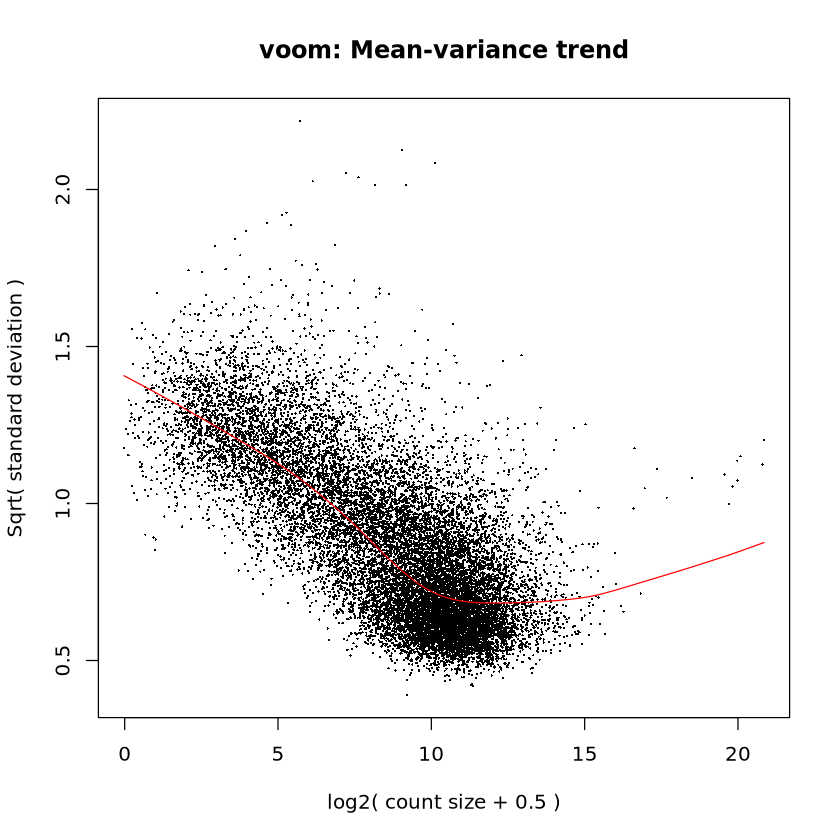

In [21]:
# Normalize the data
dge <- calcNormFactors(dge)
# Voom transformation
design <- model.matrix(~ 0 + SMTS, data = gtex_annot)
v <- voom(dge, design, plot = TRUE) 

In [22]:
# Fit linear model
fit <- lmFit(v, design)

In [23]:
# Create contrast matrix
contrast.matrix <- makeContrasts(
  Treatment_vs_Control =  SMTSBrain - SMTSLiver,
  levels = design
)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

# View top differentially expressed genes
top_genes <- topTable(fit2, adjust.method = "BH", number=Inf)

In [24]:
head(top_genes, 20)

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8682,CYP2E1,-9.817474,4.3157003,-31.07511,1.171405e-29,1.178888e-25,56.76591
15013,A1BG,-7.146197,3.2679161,-30.10331,3.974760e-29,1.824187e-25,55.84917
12740,ASGR1,-8.044474,2.1471496,-28.13563,5.290617e-28,1.257202e-24,53.02961
13865,APC2,7.732415,1.4077114,28.79636,2.178876e-28,6.040570e-25,52.59660
3206,ITIH1,-14.683777,-0.2585746,-30.92159,1.417444e-29,1.178888e-25,52.44707
8786,HPX,-11.953254,2.6465553,-27.19990,1.920361e-27,3.992910e-24,50.97868
1402,CFHR2,-15.072300,-3.1134362,-30.02612,4.386647e-29,1.824187e-25,50.13921
15022,SLC27A5,-5.550117,3.8208640,-25.22776,3.329095e-26,3.691745e-23,49.59721
12739,ASGR2,-11.239260,1.0637028,-26.65828,4.125088e-27,7.624079e-24,49.49918


# Human library

In [51]:
gmt_file <- "libs_human/gmt/WikiPathway_2023_Human.txt"
gene_sets <- getGmt(gmt_file)
gene_set_list <- setNames(lapply(gene_sets, function(x) geneIds(x)), names(gene_sets))

In [52]:
# CAMERA gene set enrichment analysis
camera_res <- camera(v, index = gene_set_list, design = design, contrast = contrast.matrix[,"Treatment_vs_Control"])

# View gene set enrichment results
camera_res[which(camera_res$FDR < 0.01 & camera_res$Direction == "Down"),]

,NGenes,Direction,PValue,FDR
,<dbl>,<chr>,<dbl>,<dbl>
Complement And Coagulation Cascades WP558,58,Down,3.231207e-17,2.588197e-14
Complement System WP2806,93,Down,1.370537e-12,5.489001e-10
Complement Activation WP545,22,Down,4.160683e-12,1.110902e-09
Disorders Of Bile Acid Synthesis And Biliary Transport WP5176,29,Down,1.099920e-11,1.971596e-09
Cholesterol Metabolism WP5304,70,Down,1.230709e-11,1.971596e-09
Tamoxifen Metabolism WP691,19,Down,1.680615e-11,2.243621e-09
Folate Metabolism WP176,62,Down,3.244779e-11,3.712954e-09
Enterocyte Cholesterol Metabolism WP5333,35,Down,1.163246e-10,1.164700e-08
Biomarkers For Urea Cycle Disorders WP4583,12,Down,1.099690e-09,8.808517e-08


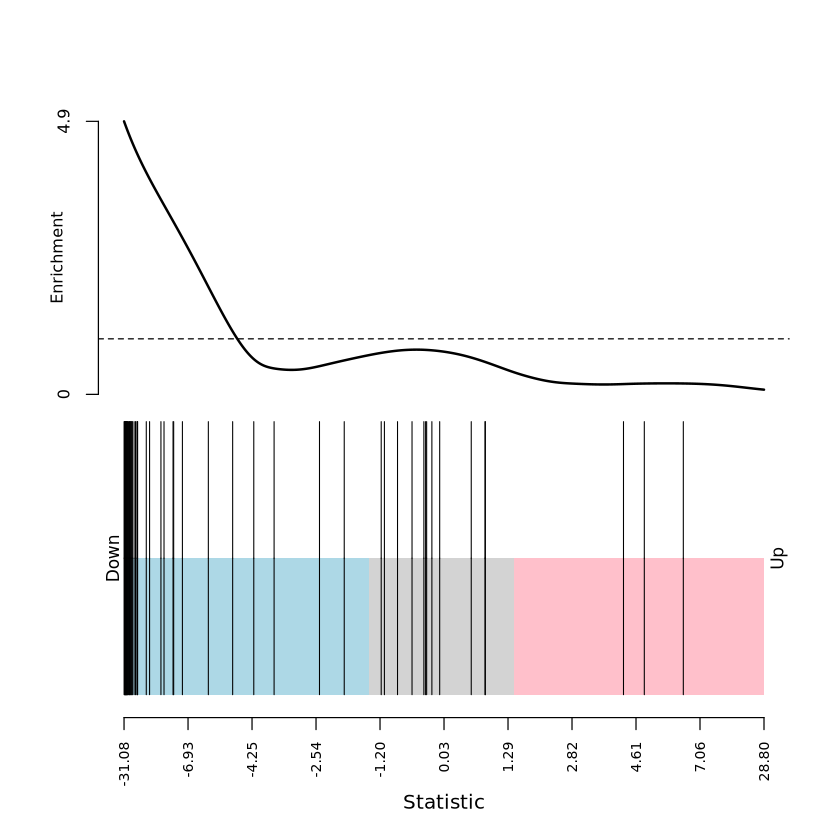

In [53]:
# Choose a gene set for the barcode plot
chosen_gene_set <- rownames(camera_res)[1]  # Choose the first gene set

# Get the gene indices for the chosen gene set
gene_indices <- gene_set_list[["Complement And Coagulation Cascades WP558"]]

# Create the barcode plot
barcodeplot(fit2$t[, 1], index = gene_indices, main = "")

Warning message:
“Removed 274 rows containing missing values or values outside the scale range
(`geom_point()`).”


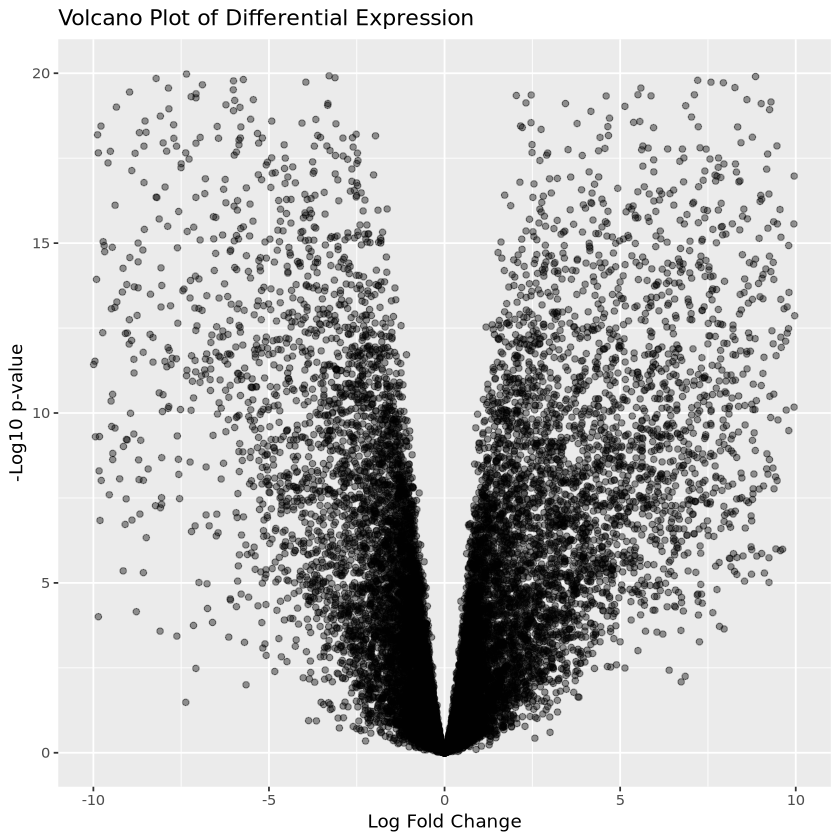

In [43]:
volcano <- ggplot(top_genes, aes(x = logFC, y = -log10(P.Value))) +
  geom_point(alpha = 0.4) +
  xlim(c(-10, 10)) +
  ylim(c(0, 20)) +
  xlab("Log Fold Change") +
  ylab("-Log10 p-value") +
  ggtitle("Volcano Plot of Differential Expression")
volcano

# LLM ensembled library

In [47]:
gmt_file2 <- "libs_human/gmt_llm_ensembled/WikiPathway_2023_Human.txt"
gene_sets2 <- getGmt(gmt_file2)
gene_set_list2 <- setNames(lapply(gene_sets2, function(x) geneIds(x)), names(gene_sets2))

In [48]:
# CAMERA gene set enrichment analysis
camera_res2 <- camera(v, index = gene_set_list2, design = design, contrast = contrast.matrix[,"Treatment_vs_Control"])

# View gene set enrichment results
camera_res2[which(camera_res2$FDR < 0.01 & camera_res2$Direction == "Down"),]

,NGenes,Direction,PValue,FDR
,<dbl>,<chr>,<dbl>,<dbl>
Complement And Coagulation Cascades WP558,29,Down,4.620242e-15,2.233371e-12
Complement Activation WP545,24,Down,5.779441e-15,2.233371e-12
Complement System WP2806,22,Down,8.656477e-15,2.233371e-12
Complement System In Neuronal Development And Plasticity WP5090,23,Down,1.315556e-11,2.545601e-09
Vitamin K Metabolism And Activation Of Dependent Proteins WP5186,8,Down,5.021200e-10,7.772817e-08
Blood Clotting Cascade WP272,20,Down,6.288899e-09,8.112679e-07
Urea Cycle And Related Diseases WP4571,9,Down,2.391706e-08,2.644544e-06
Glucuronidation WP698,12,Down,4.000308e-08,3.870298e-06
Oxidation By Cytochrome P450 WP43,21,Down,5.781629e-08,4.972201e-06


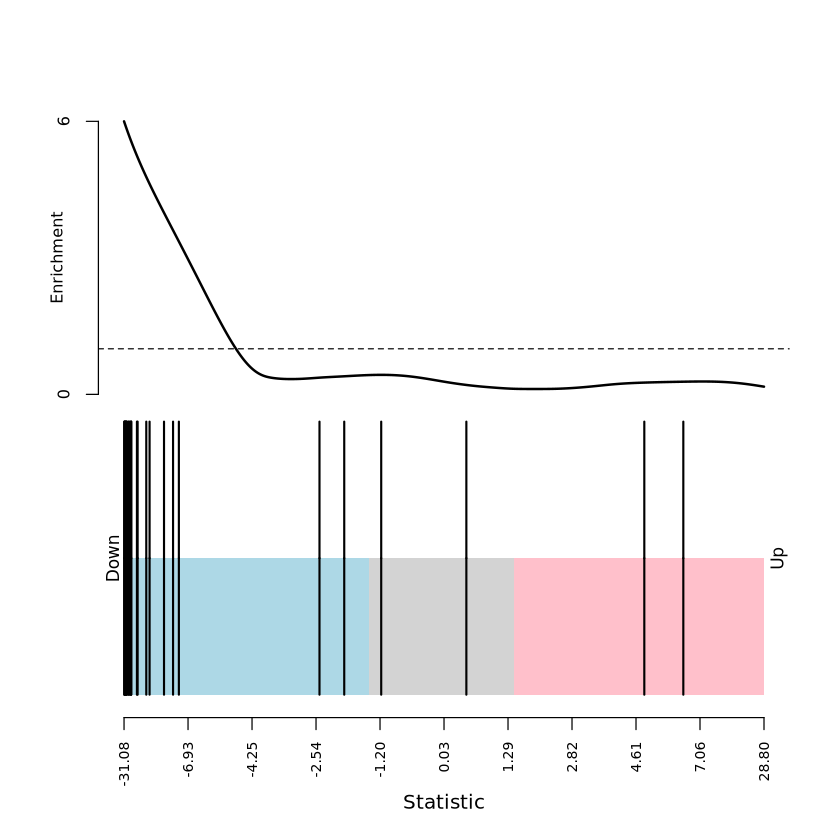

In [54]:
# Choose a gene set for the barcode plot
chosen_gene_set2 <- rownames(camera_res2)[1]  # Choose the first gene set

# Get the gene indices for the chosen gene set
gene_indices2 <- gene_set_list2[["Complement And Coagulation Cascades WP558"]]

# Create the barcode plot
barcodeplot(fit2$t[, 1], index = gene_indices2, main = "")

# Compare human and llm GSEA results

In [57]:
human_up <- rownames(camera_res[which(camera_res$FDR < 0.01 & camera_res$Direction == "Up"),])
llm_up <- rownames(camera_res2[which(camera_res2$FDR < 0.01 & camera_res2$Direction == "Up"),])

human_down <- rownames(camera_res[which(camera_res$FDR < 0.01 & camera_res$Direction == "Down"),])
llm_down <- rownames(camera_res2[which(camera_res2$FDR < 0.01 & camera_res2$Direction == "Down"),])

In [63]:
llm_up

[1] "Oligodendrocyte Specification And Differentiation Leading To Myelin Components For CNS WP4304"
[2] "Synaptic Vesicle Pathway WP2267"                                                              
[3] "Microtubule Cytoskeleton Regulation WP2038"

In [59]:
human_up

[1] "Disruption Of Postsynaptic Signaling By CNV WP4875"                
 [2] "NRXN1 Deletion Syndrome WP5398"                                    
 [3] "Synaptic Vesicle Pathway WP2267"                                   
 [4] "Splicing Factor NOVA Regulated Synaptic Proteins WP4148"           
 [5] "Calcium Regulation In Cardiac Cells WP536"                         
 [6] "Genes Related To Primary Cilium Development Based On CRISPR WP4536"
 [7] "Intraflagellar Transport Proteins Binding To Dynein WP4532"        
 [8] "Glial Cell Differentiation WP2276"                                 
 [9] "17P13 3 YWHAE Copy Number Variation WP5376"                        
[10] "Cell Type Dependent Selectivity Of CCK2R Signaling WP3679"         
[11] "GABA Receptor Signaling WP4159"                                    
[12] "PKC Gamma Calcium Signaling Pathway In Ataxia WP4760"              
[13] "G Protein Signaling Pathways WP35"                                 
[14] "Vasopressin Regulated Water Reabsorption WP5085"                   
[15] "Ciliopathies WP4803"                                               
[16] "Bardet Biedl Syndrome WP5234"                                      
[17] "Joubert Syndrome WP4656"                                           
[18] "Common Pathways Underlying Drug Addiction WP2636"

In [60]:
# Jaccard index
jaccard_index <- function(list1, list2) {
  intersection <- length(intersect(list1, list2))
  union <- length(union(list1, list2))
  jaccard <- intersection / union
  return(jaccard)
}

In [61]:
jaccard_index(human_up,llm_up)

[1] 0.05

In [62]:
jaccard_index(human_down,llm_down)

[1] 0.2446043

In [65]:
human_up

[1] "Disruption Of Postsynaptic Signaling By CNV WP4875"                
 [2] "NRXN1 Deletion Syndrome WP5398"                                    
 [3] "Synaptic Vesicle Pathway WP2267"                                   
 [4] "Splicing Factor NOVA Regulated Synaptic Proteins WP4148"           
 [5] "Calcium Regulation In Cardiac Cells WP536"                         
 [6] "Genes Related To Primary Cilium Development Based On CRISPR WP4536"
 [7] "Intraflagellar Transport Proteins Binding To Dynein WP4532"        
 [8] "Glial Cell Differentiation WP2276"                                 
 [9] "17P13 3 YWHAE Copy Number Variation WP5376"                        
[10] "Cell Type Dependent Selectivity Of CCK2R Signaling WP3679"         
[11] "GABA Receptor Signaling WP4159"                                    
[12] "PKC Gamma Calcium Signaling Pathway In Ataxia WP4760"              
[13] "G Protein Signaling Pathways WP35"                                 
[14] "Vasopressin Regulated Water Reabsorption WP5085"                   
[15] "Ciliopathies WP4803"                                               
[16] "Bardet Biedl Syndrome WP5234"                                      
[17] "Joubert Syndrome WP4656"                                           
[18] "Common Pathways Underlying Drug Addiction WP2636"

In [66]:
llm_up

[1] "Oligodendrocyte Specification And Differentiation Leading To Myelin Components For CNS WP4304"
[2] "Synaptic Vesicle Pathway WP2267"                                                              
[3] "Microtubule Cytoskeleton Regulation WP2038"